### Задание

In [1]:
import torch
import torch.nn as nn
torch.manual_seed(0)

1. Повторите шаги 1-4 из предыдущего задания со следующими изменениями:

- ширину окна $k$ из задания 3 положите равной 4;
- размерность `X` на выходе: (размер выборки, ширина окна `k`, 1).

In [9]:
import pandas as pd
import numpy as np

In [10]:
pas = pd.read_csv('data/passengers.csv', dtype={'num_passangers': np.float64})

In [11]:
pas.head(3)

,date,num_passengers
0,1949-1-1,112
1,1949-2-1,118
2,1949-3-1,132


In [12]:
x, y = pas.values[:, :-1], pas.values[:, -1]

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
mms = MinMaxScaler()

In [15]:
yr = mms.fit_transform(y.reshape(-1, 1))

In [16]:
def make_tensor(y, k):
    newX = np.array([]).reshape(0, k)
    newY = y[k:]
    for i in range(y.shape[0]-k):
        newX = np.vstack([newX, y[i:i+k,:].reshape(1, -1)])
    return torch.FloatTensor(newX), torch.FloatTensor(newY)

In [21]:
tX, ty = make_tensor(yr, 4)

In [22]:
tX.type()

'torch.FloatTensor'

In [25]:
canalsX = tX.reshape(tX.shape[0], 4, 1)

In [26]:
X_train, X_test = canalsX[:-36], canalsX[-36:]
y_train, y_test = ty[:-36], ty[-36:]

2. Реализуйте сеть LSTM для решения задачи прогнозирования объемов пассажирских авиаперевозок. Воспользуйтесь шаблоном ниже:

- в `__init__` укажите два слоя: LSTM (`torch.nn.LSTM`) и полносвязный (`torch.nn.Linear`). Для слоя LSTM укажите параметры: `input_size=1`, размер скрытого вектора $h$ `hidden_size=hidden_size`, количество слоев `num_layers=1` и `batch_first=True`;
- слой LSTM вернет последнее скрытое состояние $h_t$, которое далее должно быть передано в полносвязный слой. Учитывая это, укажите нужную размерность входного и выходного векторов в полносвязном слое `torch.nn.Linear`;
- в методе `forward` задаются начальные состояния $h_0$ и ячейки памяти $c_0$, их размерности должны совпадать;
- после применения слоя LSTM переменная `h_out` будет хранить последнее скрытое состояние, которое затем необходимо преобразовать в вектор;
- после данного преобразования примените полносвязный слой и обучите полученную сеть на 2000 эпохах с шагом обучения 0.01 (функция потерь также MSE, оптимизатор &ndash; Adam).

In [52]:
class LSTM(nn.Module):

    def __init__(self, hidden_size):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.linear_layer = nn.Linear(in_features=hidden_size, out_features=1)
        
        # при num_layers=2 и более, nn.LSTM вернет
        # соответсвующее количество последних состояний
        
    def forward(self, inputs):
        
        h_0 = torch.zeros(1, inputs.size(0), self.hidden_size)
        c_0 = torch.zeros(1, inputs.size(0), self.hidden_size)

        output_features, (h_out, _) = self.lstm(inputs, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        vect = torch.flatten(h_out, 1)
        output = self.linear_layer(vect)
        
        return output

3. Повторите шаги 7-8 из предыдущего задания.

In [53]:
model = LSTM(hidden_size=2)

In [54]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [55]:
_ = torch.manual_seed(0)

epochs = 2000
for epoch in range(epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [56]:
_ = model.eval()

In [57]:
pred = mms.inverse_transform(model(X_test).detach().numpy())

8. Отобразите на графике исходный ряд и полученный прогноз.

In [58]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Результаты прогнозирования')

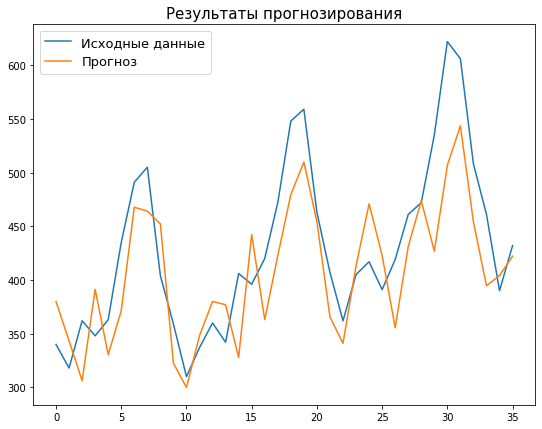

In [59]:
fig, ax = plt.subplots(figsize=(9,7))

x = range(yr[-36:].shape[0])

ax.plot(x, y[-36:], label='Исходные данные')
ax.plot(x, pred, label='Прогноз')
plt.legend(fontsize=13)
plt.title('Результаты прогнозирования', fontsize=15)

4. \* Попробуйте улучшить качество предсказаний (и CNN, и LSTM), меняя следующие параметры:

- ширину окна $k$;
- ширину окна сверточного слоя и слоя субдискретизации;
- количество слоев;
- количество нейронов скрытого слоя и т.д.